### **Crawling and scraping**

In [64]:
import requests
import bs4
import re
from time import sleep
import random
import networkx as nx
from urllib.parse import unquote, urlparse
import csv

headers = {
        'User-Agent': 'IR Project 1 - Web Crawler -'
        }

In [65]:
def getText(url):
    headers = {
        'User-Agent': 'IR Project 1 - Web Crawler -'
        }
    
    output = ""
    response = requests.get(url, headers=headers)
    parsed = bs4.BeautifulSoup(response.text)
    for p in parsed.select('p'):
        output += p.getText()
        

    return output

In [66]:
## DO NOT RERUN IF YOU ALREADY HAVE output.csv
with open("output.csv", 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['url', 'name', 'text']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
   

In [67]:
def append_to_csv(parsed, url):
    with open("output.csv", 'a', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['url', 'name', 'text']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        name = parsed.select_one('h1#firstHeading').getText()
        text = ""
        for p in parsed.select('p'):
            text += p.getText()
        writer.writerow({'url': url, 'name': name, 'text': text})

In [68]:
def bfs_graph(start_link, max_nodes=1000, per_page=3):
    """
    BFS crawling from start_link, build and plot a NetworkX graph.
    - max_nodes: limit total unique pages (nodes)
    - per_page: max outgoing links to follow per page
    Returns the built graph.
    """
    G = nx.DiGraph()
    queue = [start_link]
    visited = set()

    def short_name(url):
        path = urlparse(url).path
        if path.startswith('/wiki/'):
            name = unquote(path.split('/wiki/')[1])
            return name.replace('_', ' ')
        return url

    while queue and len(visited) < max_nodes:
        current = queue.pop(0)
        if current in visited:
            continue
        try:
            response = requests.get(current, headers=headers, timeout=10)
        except Exception:
            continue
        if response.status_code != 200:
            continue

        parsed = bs4.BeautifulSoup(response.text, 'html.parser')
        visited.add(current)
        print(f"[{len(visited)}/{max_nodes}] {current}")
        append_to_csv(parsed, current)
        # avoid non-article wiki namespaces
        links = parsed.find_all('a', attrs={'href': re.compile(r'^/wiki/(?!Help:|File:|Special:|Talk:|Category:|Portal:|Template:|Wikipedia:)')})
        def is_good_href(h):
            title = unquote(h.split('/wiki/')[1]) if '/wiki/' in h else h
            bad_keywords = ('upload', 'wizard', 'file', 'help', 'special', 'talk', 'category', 'portal', 'template')
            return not any(k.lower() in title.lower() for k in bad_keywords)
        links = [a for a in links if a.get('href') and is_good_href(a.get('href'))]
        random.shuffle(links)

        for next_link in links[:per_page]:
            href = next_link.get('href')
            if not href:
                continue
            full_link = "https://en.wikipedia.org" + href
            G.add_edge(short_name(current), short_name(full_link))

            if full_link not in visited and full_link not in queue and len(visited) + len(queue) < max_nodes:
                queue.append(full_link)

        sleep(random.random() * 1.5)  

    pos = nx.spring_layout(G, k=0.6, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=300, font_size=8, arrows=True)

    return G


[1/1000] https://en.wikipedia.org/wiki/Baldur%27s_Gate_3
[2/1000] https://en.wikipedia.org/wiki/List_of_Dungeons_%26_Dragons_video_games
[3/1000] https://en.wikipedia.org/wiki/Non-player_character
[4/1000] https://en.wikipedia.org/wiki/Owlbear
[5/1000] https://en.wikipedia.org/wiki/Overhaul_Games
[6/1000] https://en.wikipedia.org/wiki/Baldur%27s_Gate:_Siege_of_Dragonspear
[7/1000] https://en.wikipedia.org/wiki/D%26D_Beyond
[8/1000] https://en.wikipedia.org/wiki/Role-playing_video_game
[9/1000] https://en.wikipedia.org/wiki/Quick_time_event
[10/1000] https://en.wikipedia.org/wiki/Warp_(video_games)
[11/1000] https://en.wikipedia.org/wiki/Birthright_(campaign_setting)
[12/1000] https://en.wikipedia.org/wiki/Raistlin_Majere
[13/1000] https://en.wikipedia.org/wiki/Bulette_(Dungeons_%26_Dragons)
[14/1000] https://en.wikipedia.org/wiki/Steam_(service)
[15/1000] https://en.wikipedia.org/wiki/Nimble_Giant_Entertainment
[16/1000] https://en.wikipedia.org/wiki/Computing_platform
[17/1000] https:

C:\Users\tidia\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 4438 (\N{HANGUL CHOSEONG PHIEUPH-PIEUP}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\tidia\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4438 (\N{HANGUL CHOSEONG PHIEUPH-PIEUP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


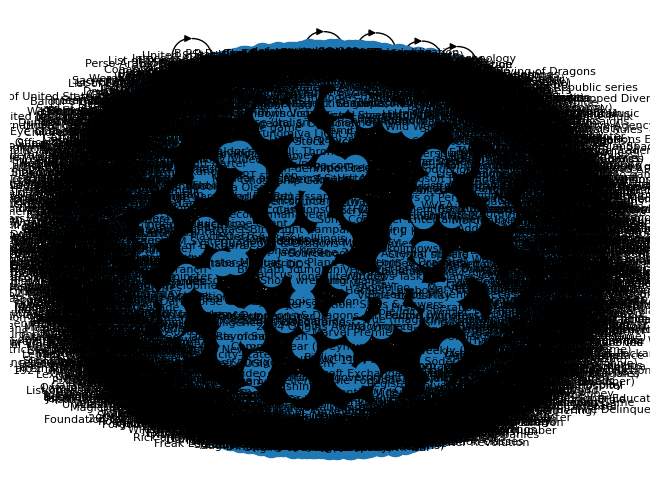

In [69]:
bfs_graph('https://en.wikipedia.org/wiki/Baldur%27s_Gate_3')

### **Stemming, lemmatization**

In [70]:
import pandas as pd
import csv
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.spatial.distance import cosine

try:
    df = pd.read_csv("output.csv")
except Exception:
    # fallback : parser avec csv.DictReader
    rows = []
    with open("output.csv", newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append(r)
    df = pd.DataFrame(rows)

In [71]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['text'] = df['text'].apply(clean_text)
print(df['text'].head())

0    Baldur's Gate 3 (also known as BG3 and Baldur'...
1    This is a list of officially licensed video ga...
2    A non-player character (NPC) is a character in...
3    An owlbear (also owl bear) is a fictional crea...
4    IdeaSpark Labs Inc. (trade name: Beamdog) is a...
Name: text, dtype: object


In [72]:
#Extract text from each url and save it in a list
texts = df['text'].tolist()
texts = texts

In [73]:
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(texts)

CountData

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 660027 stored elements and shape (1000, 71714)>

In [74]:
df_texts = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=texts)
df_texts.shape

(1000, 71714)

In [75]:
!pip install nltk
import nltk

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

porter = PorterStemmer()
lancaster = LancasterStemmer()
wordnet = WordNetLemmatizer()

def custom_stemmer(text):
  tokens = wordpunct_tokenize(text)
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word.isalpha()]
  porter = PorterStemmer()
  lemmas = [wordnet.lemmatize(word) for word in filtered_tokens]
  stems = [lancaster.stem(word) for word in lemmas]
  porter = [porter.stem(word) for word in stems]
  return porter


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tidia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tidia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tidia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tidia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
new_texts = []

for text in texts:
  new_texts.append(" ".join(custom_stemmer(text)))

new_texts

['bald gat also known bald gat ii rol play video gam lar studio third instal bald gat seri gam ful relea window hap august playst maco xbox seri x lat year gam nar parti seek cur parasit tadpol infect brain play alon group adapt fif edit tabletop rol play gam dungeon dragon bald gat tak mech set forgot realm tabletop gam play cre high custom charact embark quest parti voic comp altern play comp instead gameplay compr real tim expl larg are turn ba comb nar cho impact parti wid world outcom comb dialog world interact gen determin rol sid die bald gat bald gat ii shadow amn develop biow third gam subtitl black hound develop black isl cancel follow licen disput dungeon dragon own wizard coast wotc declin lar first pitch mak gam follow relea divin origin sin impress pre relea mat divin origin sin ii wotc welcom new pitch ev greenlit lar develop compani grew consid six year produc august lar relea gam first act ear access provid play feedback revenu ful relea lar ad fre new cont gam fin pat

In [77]:
df_simplified = df
print(df_simplified['text'].shape)
df_simplified['text'] = new_texts
df_simplified
df_simplified.to_csv("output_simplified.csv", index=False, encoding='utf-8')

(1000,)


In [78]:
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(new_texts)

CountData

new_df_texts=pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=new_texts)
print("Shape of previous df : " ,df_texts.shape)
print("Shape of new df : ", new_df_texts.shape)

Shape of previous df :  (1000, 71714)
Shape of new df :  (1000, 40703)


### **Similarities**

### First Possible Similarity

In [79]:
def jaccard(d1, d2):
    set1 = set(d1.split())
    set2 = set(d2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def closest(query, df_stemmer):
    query = custom_stemmer(query)
    query = " ".join(query)
    query_terms = set(query.split())
    max_similarity = -1
    closest_document = None

    for document, row in df_stemmer.iterrows():
        document_terms = set(document.split())
        similarity = jaccard(" ".join(query_terms), " ".join(document_terms))
        if similarity > max_similarity:
            max_similarity = similarity
            closest_document = document

    return closest_document

In [80]:
queries = [
    "Batman",
    "rpg games",
    "gaming",
    "Baldur's Gate 3",
    "Sim park",
    "Award"
]
for q in queries:
    print("query : ", q)
    closest_doc = closest(q, new_df_texts)
    for url, name, text in df_simplified.filter(['url', 'name', 'text']).itertuples(index=False):
        if closest_doc == text:
            print("closet doc : ", url, name)

query :  Batman
closet doc :  https://en.wikipedia.org/wiki/ComicsAlliance ComicsAlliance
query :  rpg games
closet doc :  https://en.wikipedia.org/wiki/List_of_Saber_Interactive_games List of Saber Interactive games
query :  gaming
closet doc :  https://en.wikipedia.org/wiki/List_of_Saber_Interactive_games List of Saber Interactive games
query :  Baldur's Gate 3
closet doc :  https://en.wikipedia.org/wiki/MacPlay MacPlay
query :  Sim park
closet doc :  https://en.wikipedia.org/wiki/Charles_Roberts_Awards_Hall_of_Fame Charles Roberts Awards Hall of Fame
query :  Award
closet doc :  https://en.wikipedia.org/wiki/2004_Origins_Award_winners 2004 Origins Award winners
